# ONNX Tutorial - Single Shot MultiBox Detector Model - Inference

The tutorial demonstrates loading trained model weights from BlobHub and using for inference. 

The model used in this tutorial is trained to scale up images (increase image resolution).

References: 
- BlobHub model  
  https://blobhub.io/onnx-vision-models/object-detection
- Original tutorial  
  https://github.com/onnx/tutorials/blob/master/tutorials/OnnxRuntimeServerSSDModel.ipynb

## Table of Contents

- [Install Dependencies](#Install-Dependencies)
- [Download Model from BlobHub](#Download-Model-from-BlobHub)
- [Run Model Inference](#Run-Model-Inference)
- [Compare Results](#Compare-Results)

## Install Dependencies

The following packages are required for this tutorial:

In [ ]:
!pip install blobhub

In [ ]:
!pip install onnx

In [4]:
!pip install numpy

In [ ]:
!pip install onnxruntime

In [ ]:
!pip install Pillow

In [ ]:
!pip install matplotlib

In [ ]:
!pip install requests

## Download Model from BlobHub

This snippet downloads model from public BlobHub blob. Blob reference:

In [6]:
ORG_ID = "onnx-vision-models"
BLOB_ID = "object-detection"

Model downloading code:

In [7]:
from blobhub.blob import Blob, Revision
from blobhub.presets.onnx import Onnx, Model       

# Find blob
blob = Blob(org_id=ORG_ID, blob_id=BLOB_ID)
revision = blob.revisions.latest()

# Initialize preset
onnx = Onnx(revision=revision)

# Download and save the model
downloaded_model = onnx.download()
assert None != downloaded_model

Downloaded model is stored locally and is accessible under:

In [141]:
downloaded_model.path

'/Users/egorpushkin/.blobhub/e9e75852-e135-4c5f-8ae0-c23fe0038f0d/5c669267-3dc3-4179-81c3-a5a2aad24dad/model.onnx'

Download the list of class labels the model is trained to recognize. Labels are stored seoarately from model ONNX blob. 

In [142]:
classes_url = "https://static.blobhub.io/revisions/5c669267-3dc3-4179-81c3-a5a2aad24dad/coco_classes.txt"
classes_response = requests.get(classes_url)
classes = classes_response.text.split("\n")

## Run Model Inference

Check model correctness (ONNX model consistency check):

In [143]:
import onnx

onnx_model = onnx.load(downloaded_model.path)
onnx.checker.check_model(onnx_model)

Initialize ONNX runtime:

In [144]:
import onnxruntime

ort_session = onnxruntime.InferenceSession(downloaded_model.path)

Load input image and convert to tensor:

In [145]:
import requests
from io import BytesIO
from PIL import Image

# Load the image 
# input_image_url = "https://static.blobhub.io/revisions/5c669267-3dc3-4179-81c3-a5a2aad24dad/interior.jpg"
input_image_url = "https://static.blobhub.io/revisions/5c669267-3dc3-4179-81c3-a5a2aad24dad/highway.jpg"
response = requests.get(input_image_url)
input_image_original = Image.open(BytesIO(response.content))

# Model parameters (can be inferred from the model topology)
resized_width = 1200  
resized_height = 1200

# Resize image to match model input dimensions
input_image = input_image_original.resize((resized_width, resized_height), Image.BILINEAR)

Convert image to model input:

In [146]:
import numpy as np

image_data = np.array(input_image)
image_data = np.transpose(image_data, [2, 0, 1])
image_data = np.expand_dims(image_data, 0)
mean_vec = np.array([0.485, 0.456, 0.406])
stddev_vec = np.array([0.229, 0.224, 0.225])
norm_image_data = np.zeros(image_data.shape).astype('float32')
for i in range(image_data.shape[1]):
    norm_image_data[:,i,:,:] = (image_data[:,i,:,:]/255 - mean_vec[i]) / stddev_vec[i]

Run inference:

In [147]:
ort_inputs = {ort_session.get_inputs()[0].name: norm_img_data}
ort_outs = ort_session.run(None, ort_inputs)

Extract model outputs:

In [148]:
bboxes = ort_outs[0].flatten()
labels = ort_outs[1].flatten()
scores = ort_outs[2].flatten()

Display image with bounding boxes and appropriate class:

<Figure size 432x288 with 0 Axes>

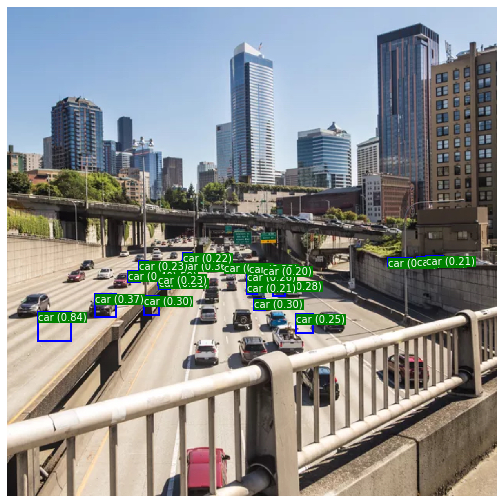

In [150]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Plot the bounding boxes on the image
plt.figure()
fig, ax = plt.subplots(1, figsize=(12,9))
ax.imshow(input_image)

# Walk over all bounding boxes found by the model
for c in range(200):
    # We pick a subset of labels based on confidence score 
    if scores[c] < 0.2:
        continue
    
    base_index = c * 4
    y1, x1, y2, x2 = bboxes[base_index] * resized_height, bboxes[base_index + 1] * resized_width, bboxes[base_index + 2] * resized_height, bboxes[base_index + 3] * resized_width 
    color = 'blue'
    box_h = (y2 - y1)
    box_w = (x2 - x1)
    bbox = patches.Rectangle((y1, x1), box_h, box_w, linewidth=2, edgecolor=color, facecolor='none')
    ax.add_patch(bbox)
    label_text = "{} ({:0.2f})".format(classes[labels[c] - 1], scores[c])
    plt.text(y1, x1, s=label_text, color='white', verticalalignment='top', bbox={'color': "green", 'pad': 0})

plt.axis('off')
plt.show()